### Run multiple models on different GPUs with the same data
This is very useful when you want to compare your hyper-parameters / models without set seed.
Set seed method has several drawbacks  

1) Time costly <br>
2) RAM memory costly <br>
3) when encounter data augmentation, you will get in trouble... fix augmentation is very annoying. (I'll make the data pipeline to accomplish when I got time to work on this...) <br>

In [1]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', default="1,2,3,4,6", type = str, help = "depends on how many GPUs on your machine and which GPU you want to get")
parser.add_argument('--frame_work', default="Keras", type = str, help = "TF / Keras")
parser.add_argument('--use_data', default="catdog", type = str, help = "mnist / cifar10 / catdog")
parser.add_argument('--epoch', default= 200, type = int)
parser.add_argument('--batch_size', default= 256, type = int)

FLAGS = parser.parse_args([])
print(FLAGS)

os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu_id
import threading
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import cifar10, cifar100
from keras.utils.np_utils import to_categorical

import keras.backend as K
from keras.models import Model, load_model, save_model
from keras.layers import Dense, Activation, Input, Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
# Modified from source: https://stackoverflow.com/questions/46712272/run-hyperparameter-optimization-on-parallel-gpus-using-tensorflow
# The original version IS NOT CORRECT, you have to add with tf.devices inside the graph

Namespace(batch_size=256, epoch=200, frame_work='Keras', gpu_id='1,2,3,4,6', use_data='catdog')


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## Define a callback for Keras model
from keras.callbacks import Callback
class K_Logger(Callback):
    def __init__(self, n, gpu_id = 0):
        self.n = n   # print loss & acc every n epochs
        self.gpu_id = gpu_id

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            # add what you need here
            train_loss = logs.get('loss')
            train_acc = logs.get('acc')
            valid_loss = logs.get('val_loss')
            valid_acc = logs.get('val_acc')
            print("GPU_ID: %s, epoch: %4d, loss: %0.5f, acc: %0.3f, val_loss: %0.5f, val_acc: %0.3f" \
                  % (self.gpu_id, epoch, 
                     train_loss, train_acc,
                     valid_loss, valid_acc))
            
class TF_Logger():
    def __init__(self, n, gpu_id = 0):
        self.n = n
        self.gpu_id = gpu_id
        # append what you need here
        self.history = {'loss': [],
                        'acc': [],
                        'val_loss': [],
                        'val_acc': []}
        
    def update(self, epoch, loss, acc, val_loss, val_acc):
        self.history['loss'].append(loss)
        self.history['acc'].append(acc)
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_acc)
        
        if epoch % self.n == 0:
            print("GPU_ID: %s, epoch: %4d, loss: %0.5f, acc: %0.3f, val_loss: %0.5f, val_acc: %0.3f" \
                  % (self.gpu_id, epoch, 
                     loss, acc,
                     val_loss, val_acc))

### Check GPU ID get

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

# list them, no matter which GPU you pick up, the order must start from 0 (e.g. CUDA_VISIBLE_DEVICES=7 ==> /device:GPU:0)
get_available_gpus()

['/device:GPU:0',
 '/device:GPU:1',
 '/device:GPU:2',
 '/device:GPU:3',
 '/device:GPU:4']

In [4]:
# Get the data
use_data = FLAGS.use_data

if use_data is 'mnist':
    dset = input_data.read_data_sets("data/mnist", one_hot=True, reshape=False)
    train_x_all = dset.train.images
    train_y_all = dset.train.labels
    test_x = dset.test.images
    test_y = dset.test.labels
elif use_data is 'cifar10':
    dtrain, dtest = cifar10.load_data()
    train_x_all, train_y_all = dtrain
    test_x, test_y = dtest
    train_y_all = to_categorical(train_y_all, num_classes=10)
    test_y = to_categorical(test_y, num_classes=10)
elif use_data is 'catdog':
    # If use this dataset, you have to import following libraries and download dataset
    # https://www.kaggle.com/c/dogs-vs-cats
    import cv2
    import glob
    import pandas as pd
    from sklearn.model_selection import train_test_split
    FLAGS.batch_size = FLAGS.batch_size // 4 
    d_path = '/home/seanyu/datasets/cat_dog/dataset/'
    train_paths = glob.glob(d_path + 'train/*.jpg')
    test_paths = glob.glob(d_path + 'test1/*.jpg')
    df_train = pd.DataFrame({'img_path': train_paths,
                             'target': [os.path.basename(i.split(".")[0]) for i in train_paths]})
    df_train['target'] = df_train.target.replace({'cat':0, 'dog':1})
    df_train, df_test = train_test_split(df_train, test_size = 0.1)
    
    def read_and_resize(img_path):
        x = cv2.imread(img_path)
        x = cv2.resize(x, (128,128))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        return x

    train_x_all = np.array([read_and_resize(i) for i in df_train.img_path], dtype=np.float32)
    train_y_all = df_train.target.values
    train_y_all = to_categorical(train_y_all, num_classes=2)

    test_x = np.array([read_and_resize(i) for i in df_test.img_path], dtype=np.float32)
    test_y = df_test.target.values
    test_y = to_categorical(test_y, num_classes=2)
    
print(train_x_all.shape)
print(train_y_all.shape)
print(test_x.shape)
print(test_y.shape)

(22500, 128, 128, 3)
(22500, 2)
(2500, 128, 128, 3)
(2500, 2)


In [5]:
def build_keras_model(input_shape, n_classes):
    # Example for a simple model
    x_in = Input(shape = input_shape)
    x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x_in)
    x = BatchNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Flatten()(x)
    y = Dense(units=n_classes, activation='softmax')(x)
    
    model = Model(inputs=[x_in], outputs=[y])
    
    return model

def build_tf_model(input_shape, n_classes):
    imd1, imd2, imd3 = input_shape
    x = tf.placeholder(tf.float32, [None, imd1, imd2, imd3], name='x')
    y = tf.placeholder(tf.float32, [None, n_classes], name='y')
    
    x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=(3,3), padding='same')
    x = tf.nn.relu(x)
    x = tf.layers.max_pooling2d(inputs=x, pool_size=(2,2), strides=(1,1))
    
    x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=(3,3), padding='same')
    x = tf.nn.relu(x)
    x = tf.layers.max_pooling2d(inputs=x, pool_size=(2,2), strides=(1,1))
    
    x = tf.layers.flatten(inputs=x)
    pred = tf.layers.dense(inputs=x, units=n_classes)
    pred = tf.nn.softmax(pred)
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1), 
                          name='cost')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred, 1), 
                                               tf.argmax(y, 1)), 
                                      tf.float32), name = 'accuracy')
    return cost

In [6]:
def harmonic_ce(har_ratio = 0.5):
    def harmonic_ce_fixed(y_true, y_pred):
        crossentropy = K.categorical_crossentropy(target=y_true, output=y_pred)
        loss = har_ratio * tf.square(crossentropy) + (1-har_ratio) * crossentropy
        return loss
    return harmonic_ce_fixed

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [7]:
# Define the graphs per device
experiment_cond = ["mse", "categorical_crossentropy", harmonic_ce(0.5), harmonic_ce(1.), focal_loss(gamma=2., alpha=.25)]
jobs = []
devices = ['/device:GPU:0', 
           '/device:GPU:1', 
           '/device:GPU:2',
           '/device:GPU:3',
           '/device:GPU:4'
          ] # depends on which GPUs you want to put them in

# Note, the optimization part was put at different place for Tensorflow and Keras version.
# For tensorflow, optimize should be placed inside tf.device (or it seems gpus not working correctly)
# For Keras, optim and compile should be placed outside tf.device (or it will throw gradient collection error)

### We use Keras in this case
if FLAGS.frame_work is "TF":
    for device, cond in zip(devices, experiment_cond):
        with tf.Graph().as_default() as graph:
            with tf.device(device):
                cost = build_tf_model(input_shape = train_x_all.shape[1:], n_classes=train_y_all.shape[1] )
                optimize = tf.train.GradientDescentOptimizer(0.001).minimize(cost, name='optimize')
        jobs.append(graph)
        
elif FLAGS.frame_work is "Keras":
    for cond, device in zip(experiment_cond, devices):
        with tf.Graph().as_default() as graph:
            with tf.device(device):
                model = build_keras_model(input_shape=(train_x_all.shape[1:]), n_classes=train_y_all.shape[1])
            # to cpu
            #optim = SGD(lr=0.0001)
            optim = Adam(lr=1e-4)
            model.compile(loss = cond, metrics= ['acc'], optimizer=optim)
        jobs.append([graph, model])
        
print(jobs)

[[<tensorflow.python.framework.ops.Graph object at 0x7f75e0d32668>, <keras.engine.training.Model object at 0x7f73f4cf2f60>], [<tensorflow.python.framework.ops.Graph object at 0x7f72c0419e80>, <keras.engine.training.Model object at 0x7f72c02193c8>], [<tensorflow.python.framework.ops.Graph object at 0x7f72c04190b8>, <keras.engine.training.Model object at 0x7f72c002d518>], [<tensorflow.python.framework.ops.Graph object at 0x7f75e0d320b8>, <keras.engine.training.Model object at 0x7f72bfdd2588>], [<tensorflow.python.framework.ops.Graph object at 0x7f72c01c3a20>, <keras.engine.training.Model object at 0x7f72bfbfa978>]]


In [8]:
# Train a graph on a device
n_epoch = FLAGS.epoch
batch_size = FLAGS.batch_size

if FLAGS.frame_work is "TF":
    def train(device, graph):
        graph.history = TF_Logger(n = 5, gpu_id = device)
        print("Start training on %s" % device)
        with tf.Session(graph=graph) as session:
            total_batch = int(train_x_all.shape[0] / batch_size)
            total_val_step = int(test_x.shape[0] / batch_size)
            
            x = graph.get_tensor_by_name('x:0')
            y = graph.get_tensor_by_name('y:0')
            cost_op = graph.get_tensor_by_name('cost:0')
            accuracy_op = graph.get_tensor_by_name('accuracy:0')
            optimize_op = graph.get_operation_by_name('optimize')
            
            session.run(tf.global_variables_initializer())
            print("Start Running")
            for epoch in range(n_epoch):
                epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
                for i in range(total_batch):
                    batch_x = train_x_all[i * batch_size:(i + 1) * batch_size]
                    batch_y = train_y_all[i * batch_size:(i + 1) * batch_size]
                    
                    _, loss, acc = session.run([optimize_op, cost_op, accuracy_op], 
                                                feed_dict={x: batch_x, y: batch_y})
                    
                    epoch_loss.append(loss)
                    epoch_acc.append(acc)
                    
                epoch_loss = np.mean(epoch_loss)
                epoch_acc = np.mean(epoch_acc)
                
                for i in range(total_val_step):
                    batch_x = test_x[i * batch_size:(i + 1) * batch_size]
                    batch_y = test_y[i * batch_size:(i + 1) * batch_size]
                    
                    val_loss, val_accuracy = session.run([cost_op, accuracy_op], 
                                                         feed_dict={x: batch_x, y: batch_y})
                    epoch_val_loss.append(val_loss)
                    epoch_val_acc.append(val_accuracy)
                    
                epoch_val_loss = np.mean(epoch_val_loss)
                epoch_val_acc = np.mean(epoch_val_acc)
                    
                # Link it to logger
                graph.history.update(epoch, epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc)
                        
elif FLAGS.frame_work is "Keras":
    def train(device, graph, model):
        print("Start training on %s" % device)
        logger = K_Logger(n = 5, gpu_id = device)
        reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=0, monitor='val_loss')
        with tf.Session(graph=graph) as session:
            K.set_session(session=session)
            model.fit(x = train_x_all, 
                      y = train_y_all, 
                      batch_size=batch_size, 
                      epochs=n_epoch, 
                      verbose=0, 
                      validation_data=(test_x, test_y), callbacks=[reduce_lr, logger])

# Start threads in parallel
train_threads = []
for i, item in enumerate(jobs):
    if FLAGS.frame_work is "TF":
        this_graph = item
        train_threads.append(threading.Thread(target=train, args=(devices[i], this_graph)))
    elif FLAGS.frame_work is "Keras":
        this_graph = item[0]
        this_model = item[1]
        train_threads.append(threading.Thread(target=train, args=(devices[i], this_graph, this_model)))
for t in train_threads:
    t.start()
for t in train_threads:
    t.join()
    
print("== Done ==")

Start training on /device:GPU:0Start training on /device:GPU:2Start training on /device:GPU:3Start training on /device:GPU:1Start training on /device:GPU:4




GPU_ID: /device:GPU:0, epoch:    0, loss: 0.21505, acc: 0.687, val_loss: 0.18111, val_acc: 0.730
GPU_ID: /device:GPU:2, epoch:    0, loss: 0.65015, acc: 0.633, val_loss: 0.79254, val_acc: 0.588
GPU_ID: /device:GPU:1, epoch:    0, loss: 0.64192, acc: 0.667, val_loss: 0.56314, val_acc: 0.716
GPU_ID: /device:GPU:3, epoch:    0, loss: 0.68708, acc: 0.621, val_loss: 0.52510, val_acc: 0.673
GPU_ID: /device:GPU:4, epoch:    0, loss: 15.70765, acc: 0.634, val_loss: 11.71888, val_acc: 0.685
GPU_ID: /device:GPU:0, epoch:    5, loss: 0.11040, acc: 0.849, val_loss: 0.15823, val_acc: 0.778
GPU_ID: /device:GPU:1, epoch:    5, loss: 0.37375, acc: 0.835, val_loss: 0.46876, val_acc: 0.789
GPU_ID: /device:GPU:2, epoch:    5, loss: 0.36606, acc: 0.819, val_loss: 0.44846, val_acc: 0.780
GPU_ID: /device:GPU:4, epoch:    5, loss: 7.07018, acc: 0.806,

GPU_ID: /device:GPU:4, epoch:   80, loss: 1.90480, acc: 0.971, val_loss: 9.53490, val_acc: 0.810
GPU_ID: /device:GPU:3, epoch:   80, loss: 0.09353, acc: 0.968, val_loss: 0.47003, val_acc: 0.811
GPU_ID: /device:GPU:0, epoch:   85, loss: 0.02672, acc: 0.983, val_loss: 0.13079, val_acc: 0.818
GPU_ID: /device:GPU:1, epoch:   85, loss: 0.06981, acc: 0.991, val_loss: 0.47025, val_acc: 0.832
GPU_ID: /device:GPU:2, epoch:   85, loss: 0.14287, acc: 0.955, val_loss: 0.50246, val_acc: 0.820
GPU_ID: /device:GPU:4, epoch:   85, loss: 1.91425, acc: 0.972, val_loss: 9.54813, val_acc: 0.811
GPU_ID: /device:GPU:3, epoch:   85, loss: 0.09380, acc: 0.966, val_loss: 0.47034, val_acc: 0.811
GPU_ID: /device:GPU:0, epoch:   90, loss: 0.02684, acc: 0.983, val_loss: 0.13069, val_acc: 0.817
GPU_ID: /device:GPU:1, epoch:   90, loss: 0.06949, acc: 0.991, val_loss: 0.46967, val_acc: 0.832
GPU_ID: /device:GPU:2, epoch:   90, loss: 0.14320, acc: 0.956, val_loss: 0.50256, val_acc: 0.820
GPU_ID: /device:GPU:4, epoch: 

GPU_ID: /device:GPU:3, epoch:  160, loss: 0.09398, acc: 0.968, val_loss: 0.47121, val_acc: 0.811
GPU_ID: /device:GPU:0, epoch:  170, loss: 0.02679, acc: 0.983, val_loss: 0.13075, val_acc: 0.818
GPU_ID: /device:GPU:1, epoch:  170, loss: 0.06985, acc: 0.991, val_loss: 0.46924, val_acc: 0.832
GPU_ID: /device:GPU:2, epoch:  170, loss: 0.14363, acc: 0.954, val_loss: 0.50121, val_acc: 0.819
GPU_ID: /device:GPU:4, epoch:  170, loss: 1.92060, acc: 0.971, val_loss: 9.54695, val_acc: 0.810
GPU_ID: /device:GPU:3, epoch:  165, loss: 0.09365, acc: 0.967, val_loss: 0.47053, val_acc: 0.811
GPU_ID: /device:GPU:0, epoch:  175, loss: 0.02676, acc: 0.984, val_loss: 0.13073, val_acc: 0.818
GPU_ID: /device:GPU:1, epoch:  175, loss: 0.07040, acc: 0.990, val_loss: 0.46963, val_acc: 0.832
GPU_ID: /device:GPU:2, epoch:  175, loss: 0.14277, acc: 0.955, val_loss: 0.50229, val_acc: 0.819
GPU_ID: /device:GPU:4, epoch:  175, loss: 1.91617, acc: 0.971, val_loss: 9.52839, val_acc: 0.812
GPU_ID: /device:GPU:3, epoch: 

## Get the result and plot it

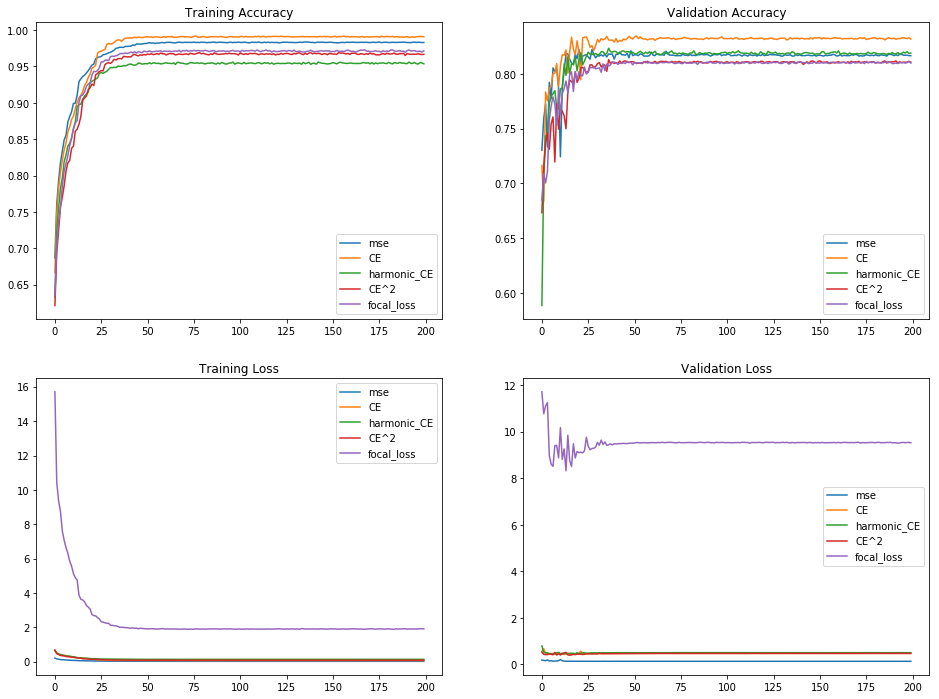

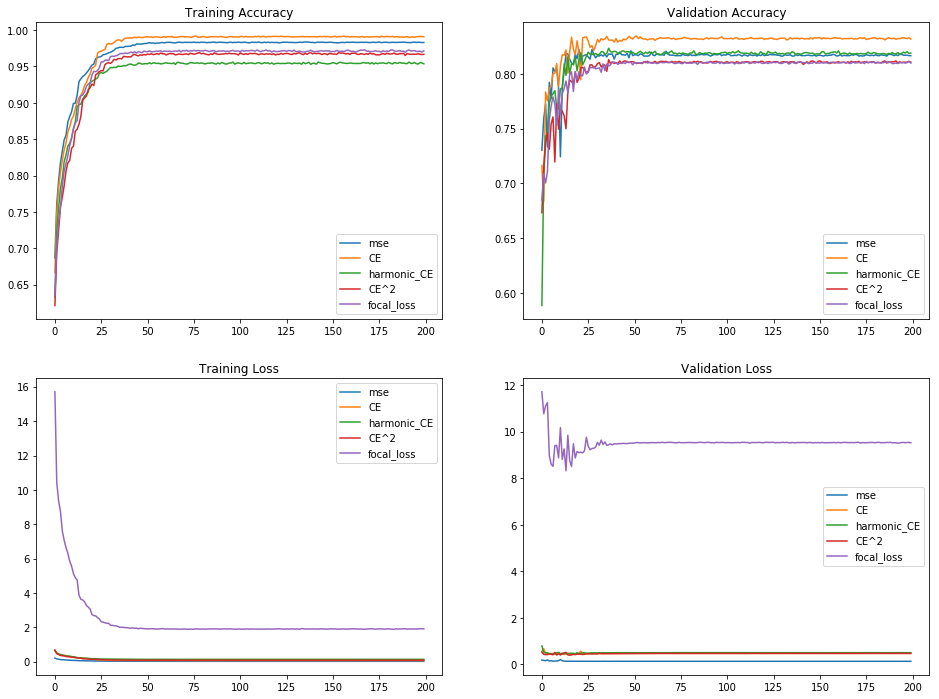

In [11]:
exp_tag = ['mse', 'CE', 'harmonic_CE', 'CE^2', 'focal_loss']
his = []
for i in jobs:
    his.append(i[1].history.history)

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
for history, cond in zip(his, exp_tag):
    plt.plot(np.arange(len(history['acc'])), history['acc'], '-', label = cond)
plt.legend()
plt.title("Training Accuracy")

plt.subplot(2,2,2)
for history, cond in zip(his, exp_tag):
    plt.plot(np.arange(len(history['val_acc'])), history['val_acc'], '-', label = cond)
plt.legend()
plt.title("Validation Accuracy")

plt.subplot(2,2,3)
for history, cond in zip(his, exp_tag):
    plt.plot(np.arange(len(history['loss'])), history['loss'], '-', label = cond)
plt.legend()
plt.title("Training Loss")

plt.subplot(2,2,4)
for history, cond in zip(his, exp_tag):
    plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], '-', label = cond)
plt.legend()
plt.title("Validation Loss")

plt.show()
#plt.savefig('CATDOG_Adam_epoch_200.png')